In [46]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
import os 
import networkx as nx
import igraph as ig
from ts2vg import NaturalVG
from scipy.spatial.distance import euclidean
from networkx import to_numpy_array

In [47]:
# data input

# load all timeseries in file
timeseries = []
datadir = "Data\PreviousData_v2\\"
for each in os.listdir("Data\PreviousData_v2"):
    timeseries.append(list(scipy.io.loadmat(datadir+each)["X"][0]))

# plt.plot(timeseries[0])

# focus on one timeseries for testing
cnt = 0
temp = []
timeseriesSlices = []
for i in range(len(timeseries[0])):
    if cnt < 150:
        temp.append(timeseries[0][i])
        cnt += 1
    else:
        if len(temp) == 150:
            timeseriesSlices.append(temp)
        temp = []
        cnt = 0

#SVD on data set beforehand to reduce the number of nodes required to iterate

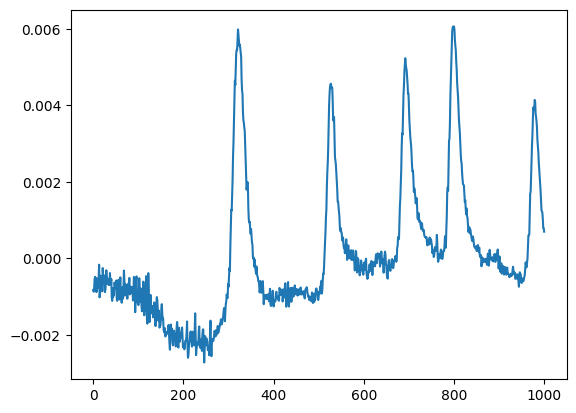

In [48]:
ts = timeseries[0][:1001]

# builds natural visibility graph
vg = NaturalVG()
vg.build(ts)

import matplotlib.pyplot as plt
ig.plot(vg.as_igraph())
plt.plot(timeseries[0][:1001])


In [49]:
# convert time series into natural visibility graphes
# https://github.com/CarlosBergillos/ts2vg

def construct_visibilty_graph(ts):
    # builds natural visibility graph
    vg = NaturalVG()
    vg.build(ts)
    # converts to networkx graph format
    g = vg.as_networkx()
    return g

def get_degree_sequence(vg):
    # get [(node, degrees),...] from a vg
    # convert to dict
    # get values (the degrees)
    ds = list(dict(nx.degree(vg)).values())
    return ds

# Calculate the distance matrix for a single time series segment
# def get_distance_matrix(individualSignalSliced):
#     n = len(individualSignalSliced)
#     distance_matrix = np.zeros((n, n))
#     for i in range(n):
#         for j in range(i, n):
#             print(individualSignalSliced[i])
#             ki = get_degree_centrality(individualSignalSliced[i])
#             kj = get_degree_centrality(individualSignalSliced[j])
#             d = np.linalg.norm(np.array(ki) - np.array(kj))
#             distance_matrix[i, j] = d
#             distance_matrix[j, i] = d
#     return distance_matrix

(122, 150)
(122, 150)
(122, 150)
(122, 122)
(122, 122)


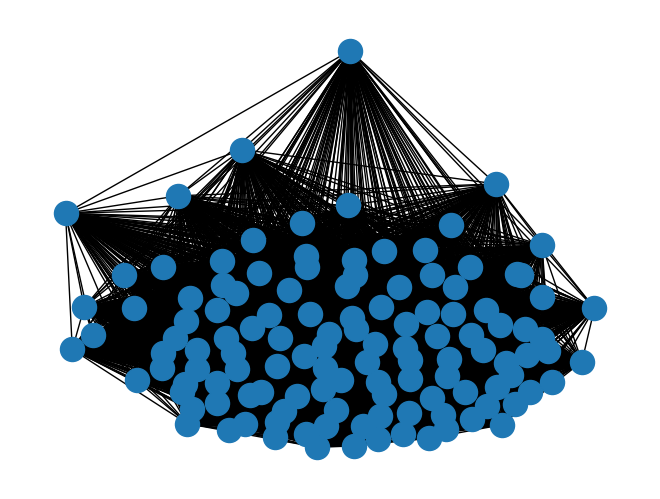

In [50]:
import numpy as np
import networkx as nx

L = 150

# segment y_filtered into consecutive non-overlapping intervals
segments = [timeseries[0][i:i+L] for i in range(0, len(timeseries[0]), L) if len(timeseries[0][i:i+L]) == L]
print(np.array(segments).shape)

# construct a visibility graph for each segment
graphs = [construct_visibilty_graph(segment) for segment in segments]
print(np.array(graphs).shape)

# compute feature vectors for each graph using degree centrality
feature_vectors = [np.array(list(nx.degree_centrality(graph).values())) for graph in graphs]
print(np.array(feature_vectors).shape)

# define distance matrix D for each segment using Euclidean distance
distance_matrices = []
for i in range(len(feature_vectors)):
    D = np.zeros((len(feature_vectors), len(feature_vectors)))
    for j in range(len(feature_vectors)):
        D[i][j] = np.linalg.norm(feature_vectors[i]-feature_vectors[j])
    distance_matrices.append(D)

# compute global distance matrix by averaging distances across all segments
global_distance_matrix = np.mean(distance_matrices, axis=0)
print(np.array(global_distance_matrix).shape)

# normalize global distance matrix between 0 and 1
normalized_distance_matrix = 1 - (global_distance_matrix - np.min(global_distance_matrix)) / (np.max(global_distance_matrix) - np.min(global_distance_matrix))
print(np.array(normalized_distance_matrix).shape)

# construct weighted graph C using normalized distance matrix as adjacency matrix
# threshold = 0.0  # set a threshold to remove weak edges
# C = nx.from_numpy_array(normalized_distance_matrix * (normalized_distance_matrix >= threshold))

C = nx.from_numpy_array(normalized_distance_matrix)

# Set edge weights to similarity values
for u, v, d in C.edges(data=True):
    d['weight'] = normalized_distance_matrix[u][v]
    
# Remove self-loops
C.remove_edges_from(nx.selfloop_edges(C))

weightedGraph = C

# Draw the weighted graph
nx.draw(C)


In [51]:

# print("Finding degree sequences or 'feature vectors'")
# # construct a degree seq for all all timeseries
# degreeSequences = [get_degree_sequence(vg) for vg in vgTimeseries]
# print(len(degreeSequences[0]))


# print("Finding distance matrices")
# from sklearn.metrics.pairwise import euclidean_distances

# print("Computing distance matrix")

# distanceMatrix = np.vstack(degreeSequences)
# print(distanceMatrix)
# print(distanceMatrix.shape)

# # compute distance matrix - old method
# # DMs = []
# # A = nx.to_numpy_array(vgTimeseries[0])  # adjacency matrix of visibility graph
# # K = A / A.sum(axis=1)[:, None]  # row-normalized adjacency matrix
# # D = euclidean_distances(K)  # compute pairwise Euclidean distances between rows of K
# # DMs.append(D)

# # # compute global distance matrix (simple average of matrices in DMs)
# gDM = np.zeros_like(DMs[0])
# for DM in DMs:
#     gDM += DM
# gDM /= len(DMs)
# print("Normalizing the distance matrix")
# # compute normalized distance matrix
# dmMin = np.min(gDM)
# dmMax = np.max(gDM)
# dmNorm = (D - dmMin) / (dmMax - dmMin)

# print("Computing similiarity matrix")
# # Compute similarity matrix
# simMatrix = 1 - dmNorm

# print(gDM)
# print(dmNorm)

# print(dmNorm.shape)


In [52]:
# import networkx as nx
# from scipy.sparse import csr_matrix

# This is bad becuase there are not a lot of 0s in the matrix

# # Convert similarity matrix to sparse format
# S_sparse = csr_matrix(simMatrix)

# # Create empty weighted graph
# weightedGraph = nx.Graph()

# # Add edges and weights from sparse similarity matrix
# for i, j, w in zip(*S_sparse.nonzero(), S_sparse.data):
#     if i != j:  # Ignore self-loops
#         weightedGraph.add_edge(i, j, weight=w)

# # Normalize edge weights to [0, 1]
# max_weight = max(w for _, _, w in weightedGraph.edges(data='weight'))
# for u, v, d in weightedGraph.edges(data=True):
#     d['weight'] /= max_weight

# print("Drawing Weighted Graph")
# nx.draw(weightedGraph)


{0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0, 15: 1, 16: 0, 17: 1, 18: 0, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 0, 29: 0, 30: 0, 31: 0, 32: 1, 33: 0, 34: 0, 35: 0, 36: 0, 37: 1, 38: 1, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 1, 48: 0, 49: 0, 50: 1, 51: 1, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 1, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 1, 71: 0, 72: 0, 73: 0, 74: 1, 75: 1, 76: 0, 77: 0, 78: 0, 79: 1, 80: 1, 81: 1, 82: 1, 83: 0, 84: 1, 85: 0, 86: 0, 87: 1, 88: 0, 89: 0, 90: 0, 91: 1, 92: 1, 93: 0, 94: 0, 95: 0, 96: 1, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 1, 103: 1, 104: 0, 105: 1, 106: 0, 107: 0, 108: 0, 109: 0, 110: 1, 111: 0, 112: 0, 113: 0, 114: 0, 115: 1, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 1}


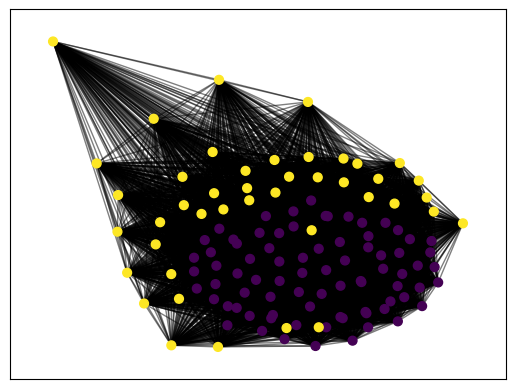

In [55]:
# community detection (clustering) of weighted graphes
# https://github.com/taynaud/python-louvain

# To achieve a modular visualization of the clusters detected by the discussed method and their
# mutual connections, we used a force-directed algorithm, namely the Frushterman–Reingold layout,
# as a graphical representation.
# Finally, for specific unsupervised FSS purposes, we considered a representative parameter for
# each cluster. Such parameters were identified based on their importance within the communities,
# by considering the signals with highest total degree centrality in their respective groups.

from community import community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt

partition = community_louvain.best_partition(weightedGraph)

print(partition)

# draw the graph
pos = nx.spring_layout(weightedGraph)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(weightedGraph, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(weightedGraph, pos, alpha=0.5)
plt.show()


{0, 1}


KeyError: 122

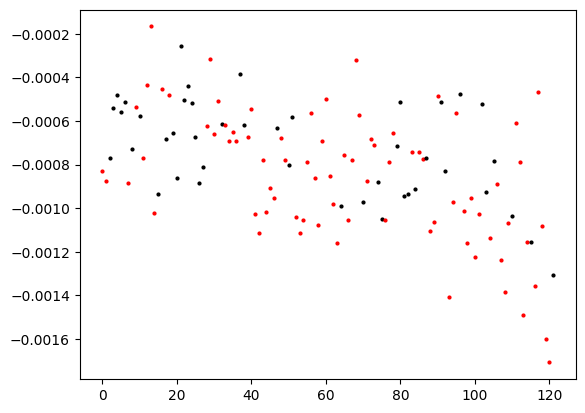

In [54]:
import matplotlib.pyplot as plt
print(set(list(partition.values())))

colors = {0: "0", 1: 'red', 2: 'blue', 3: 'green', 4: 'orange', 5: 'purple', 6:"m", 7:"c", 8: "y", 9:"0.8"}

# Plot the line with colors for each point
for i in range(len(timeseries[0])):
        plt.plot(i, timeseries[0][i], marker='o', markersize=2, color=colors[partition[i]])
        
plt.show()



In [ ]:
# pruning of graphes
# perform edge pruning by filtering the pairwise similarities lower than the second quantile of their probability distribution